# Sprint 1 Lab Experimentação e Medição de software

# 1. SETUP INICIAL E INSTALAÇÕES


In [1]:
# Instalar bibliotecas necessárias
!pip install requests pandas matplotlib seaborn

print("Bibliotecas instaladas com sucesso!")


Bibliotecas instaladas com sucesso!


In [2]:
import requests
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from io import StringIO
import random

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


# 2. CONFIGURAÇÃO DO TOKEN
## Necessário inserir seu próprio Token

In [20]:
# Configuração do token GitHub
TOKEN = "seu_github_token_aqui"

# Headers para API
headers = {
    'Authorization': f'Bearer {TOKEN}',
    'Content-Type': 'application/json'
}

base_url = 'https://api.github.com/graphql'

print("Token configurado!")

Token configurado!


# 3. TESTE DE CONECTIVIDADE

In [4]:
def test_github_connection(token):
    """Testa conectividade e validade do token"""
    headers = {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }

    simple_query = '''
    query {
      viewer {
        login
      }
    }
    '''

    payload = {'query': simple_query}

    try:
        response = requests.post(
            'https://api.github.com/graphql',
            headers=headers,
            json=payload
        )

        print(f"Status Code: {response.status_code}")

        if response.status_code == 200:
            result = response.json()
            if 'data' in result and 'viewer' in result['data']:
                print(f"✅ Token válido! Usuário: {result['data']['viewer']['login']}")
                return True
            else:
                print("❌ Token inválido ou sem permissões")
                return False
        else:
            print(f"❌ Erro: {response.status_code}")
            print(response.text)
            return False

    except Exception as e:
        print(f"❌ Erro de conexão: {e}")
        return False

# Executar teste
print("🔍 Testando conexão com GitHub...")
test_github_connection(TOKEN)


🔍 Testando conexão com GitHub...
Status Code: 200
✅ Token válido! Usuário: yG2y


True

# 4. DIAGNÓSTICO COMPLETO



In [5]:
def run_complete_diagnosis(token):
    """Diagnóstico completo de problemas de conectividade"""
    print(" IAGNÓSTICO COMPLETO DE CONECTIVIDADE")
    print("=" * 50)

    try:
        status_response = requests.get('https://www.githubstatus.com/api/v2/status.json', timeout=10)
        if status_response.status_code == 200:
            status = status_response.json()
            print(f"✅ Status GitHub API: {status.get('status', {}).get('description', 'OK')}")
        else:
            print("⚠️ Não foi possível verificar status do GitHub")
    except:
        print("❌ Erro ao verificar status do GitHub")

    try:
        ping_response = requests.get('https://api.github.com', timeout=10)
        print(f"✅ Conectividade GitHub: Status {ping_response.status_code}")
    except:
        print("❌ Problema de conectividade com GitHub")

    # 3. Verificar rate limits
    if token and token != "seu_github_token_aqui":
        headers = {'Authorization': f'Bearer {token}'}
        try:
            rate_response = requests.get('https://api.github.com/rate_limit', headers=headers)
            if rate_response.status_code == 200:
                rate_data = rate_response.json()
                graphql_limit = rate_data.get('resources', {}).get('graphql', {})
                print(f"✅ GraphQL Rate Limit: {graphql_limit.get('remaining', 'N/A')}/{graphql_limit.get('limit', 'N/A')}")
                print(f"✅ REST Rate Limit: {rate_data['rate']['remaining']}/{rate_data['rate']['limit']}")
            else:
                print("⚠️ Não foi possível verificar rate limit")
        except:
            print("❌ Erro ao verificar rate limit")
    else:
        print("⚠️ Token ainda não configurado - não é possível verificar rate limits")

    print("=" * 50)

run_complete_diagnosis(TOKEN)


 IAGNÓSTICO COMPLETO DE CONECTIVIDADE
✅ Status GitHub API: All Systems Operational
✅ Conectividade GitHub: Status 200
✅ GraphQL Rate Limit: 4999/5000
✅ REST Rate Limit: 5000/5000


# 5. COLETOR PRINCIPAL COM RETRY

In [7]:
class GitHubDataCollectorImproved:
    """Coletor de dados GitHub com tratamento robusto de erros"""

    def __init__(self, token):
        self.token = token
        self.headers = {
            'Authorization': f'Bearer {token}',
            'Content-Type': 'application/json'
        }
        self.base_url = 'https://api.github.com/graphql'

    def execute_query_with_retry(self, query, variables=None, max_retries=3):
        """Executa consulta GraphQL com retry automático para tratar erros temporários"""
        for attempt in range(max_retries):
            try:
                payload = {
                    'query': query,
                    'variables': variables or {}
                }

                response = requests.post(
                    self.base_url,
                    headers=self.headers,
                    json=payload,
                    timeout=30
                )

                if response.status_code == 200:
                    return response.json()
                elif response.status_code == 502:
                    print(f"⚠️ Erro 502 (Bad Gateway) - Tentativa {attempt + 1}/{max_retries}")
                    if attempt < max_retries - 1:
                        wait_time = (2 ** attempt) + random.uniform(0, 1)
                        print(f"🔄 Aguardando {wait_time:.1f}s antes da próxima tentativa...")
                        time.sleep(wait_time)
                        continue
                else:
                    print(f"❌ Erro HTTP: {response.status_code}")
                    print(response.text[:500])
                    return None

            except requests.exceptions.Timeout:
                print(f"⏰ Timeout na tentativa {attempt + 1}/{max_retries}")
                if attempt < max_retries - 1:
                    time.sleep(5)
                    continue
            except requests.exceptions.ConnectionError:
                print(f"🌐 Erro de conexão na tentativa {attempt + 1}/{max_retries}")
                if attempt < max_retries - 1:
                    time.sleep(10)
                    continue
            except Exception as e:
                print(f"❌ Erro inesperado na tentativa {attempt + 1}/{max_retries}: {e}")
                if attempt < max_retries - 1:
                    time.sleep(5)
                    continue

        print("❌ Todas as tentativas de consulta falharam")
        return None

    def calculate_age_days(self, created_at):
        """Calcula idade do repositório em dias"""
        if not created_at:
            return None
        created_date = datetime.fromisoformat(created_at.replace('Z', '+00:00'))
        current_date = datetime.now(created_date.tzinfo)
        return (current_date - created_date).days

    def calculate_days_since(self, date_str):
        """Calcula dias desde uma data específica"""
        if not date_str:
            return None
        return self.calculate_age_days(date_str)

    def get_top_repositories(self, limit=100):
        """
        Coleta repositórios mais populares com TODOS os dados necessários para as RQs
        Query expandida para Lab01S01
        """

        # Query completa com todos os dados para todas as RQs
        complete_query = '''
        query getTopRepositories($after: String) {
          search(
            query: "stars:>1000"
            type: REPOSITORY
            first: 50
            after: $after
          ) {
            repositoryCount
            pageInfo {
              hasNextPage
              endCursor
            }
            edges {
              node {
                ... on Repository {
                  # Identificação básica
                  name
                  nameWithOwner
                  url
                  description

                  # RQ01: Maturidade/Idade
                  createdAt

                  # RQ02: Atividade/Atualizações
                  updatedAt
                  pushedAt

                  # RQ03: Linguagens
                  primaryLanguage {
                    name
                  }
                  languages(first: 10) {
                    edges {
                      node {
                        name
                      }
                      size
                    }
                  }

                  # Métricas de popularidade
                  stargazerCount
                  forkCount
                  watcherCount

                  # RQ04: Releases
                  releases {
                    totalCount
                  }
                  latestRelease {
                    createdAt
                    tagName
                  }

                  # RQ05: Issues e Pull Requests
                  issues {
                    totalCount
                  }
                  pullRequests {
                    totalCount
                  }

                  # Estados específicos para análise
                  openIssues: issues(states: OPEN) {
                    totalCount
                  }
                  closedIssues: issues(states: CLOSED) {
                    totalCount
                  }

                  openPRs: pullRequests(states: OPEN) {
                    totalCount
                  }
                  closedPRs: pullRequests(states: CLOSED) {
                    totalCount
                  }
                  mergedPRs: pullRequests(states: MERGED) {
                    totalCount
                  }

                  # RQ06: Contribuições e colaboração
                  collaborators {
                    totalCount
                  }

                  # Informações de commits
                  defaultBranchRef {
                    target {
                      ... on Commit {
                        history(first: 1) {
                          totalCount
                          edges {
                            node {
                              committedDate
                              author {
                                user {
                                  login
                                }
                              }
                            }
                          }
                        }
                      }
                    }
                  }

                  # Metadados úteis
                  isArchived
                  isFork
                  isPrivate
                  licenseInfo {
                    name
                  }
                }
              }
            }
          }
        }
        '''

        repositories = []
        cursor = None
        collected = 0
        consecutive_failures = 0

        print("🚀 Iniciando coleta COMPLETA para Lab01S01...")
        print("📊 Coletando TODOS os dados necessários para as RQs...")

        while collected < limit:
            variables = {'after': cursor} if cursor else {}
            result = self.execute_query_with_retry(complete_query, variables)

            if not result or 'data' not in result:
                consecutive_failures += 1
                print(f"❌ Falha consecutiva #{consecutive_failures}")

                if consecutive_failures >= 3:
                    print("❌ Muitas falhas consecutivas. Interrompendo coleta.")
                    break

                print("⏸️ Aguardando 30 segundos antes de tentar novamente...")
                time.sleep(30)
                continue

            # Reset contador de falhas
            consecutive_failures = 0

            search_result = result['data']['search']

            for edge in search_result['edges']:
                repo = edge['node']

                # Processar linguagens
                languages_data = []
                total_language_size = 0
                if repo['languages'] and repo['languages']['edges']:
                    for lang_edge in repo['languages']['edges']:
                        size = lang_edge['size']
                        languages_data.append({
                            'name': lang_edge['node']['name'],
                            'size': size
                        })
                        total_language_size += size

                # Processar release mais recente
                last_release_date = None
                if repo['latestRelease']:
                    last_release_date = repo['latestRelease']['createdAt']

                # Processar commits
                total_commits = 0
                last_commit_date = None
                last_commit_author = None

                if (repo['defaultBranchRef'] and
                    repo['defaultBranchRef']['target'] and
                    repo['defaultBranchRef']['target']['history']):

                    history = repo['defaultBranchRef']['target']['history']
                    total_commits = history['totalCount']

                    if history['edges'] and len(history['edges']) > 0:
                        commit = history['edges'][0]['node']
                        last_commit_date = commit['committedDate']
                        if commit['author'] and commit['author']['user']:
                            last_commit_author = commit['author']['user']['login']

                # Compilar dados completos
                repo_data = {
                    # Identificação
                    'name': repo['name'],
                    'full_name': repo['nameWithOwner'],
                    'url': repo['url'],
                    'description': repo['description'] or '',

                    # RQ01: Maturidade e Idade
                    'created_at': repo['createdAt'],
                    'age_days': self.calculate_age_days(repo['createdAt']),
                    'age_years': round(self.calculate_age_days(repo['createdAt']) / 365.25, 2),

                    # RQ02: Atividade e Atualizações
                    'updated_at': repo['updatedAt'],
                    'pushed_at': repo['pushedAt'],
                    'last_commit_date': last_commit_date,
                    'last_commit_author': last_commit_author,
                    'days_since_last_update': self.calculate_days_since(repo['updatedAt']),
                    'days_since_last_push': self.calculate_days_since(repo['pushedAt']),
                    'days_since_last_commit': self.calculate_days_since(last_commit_date),

                    # RQ03: Linguagens
                    'primary_language': repo['primaryLanguage']['name'] if repo['primaryLanguage'] else 'Unknown',
                    'languages_count': len(languages_data),
                    'total_language_size': total_language_size,
                    'languages_list': [lang['name'] for lang in languages_data],

                    # Métricas de popularidade
                    'star_count': repo['stargazerCount'],
                    'fork_count': repo['forkCount'],
                    'watcher_count': repo['watcherCount'],

                    # RQ04: Releases
                    'releases_count': repo['releases']['totalCount'],
                    'last_release_date': last_release_date,
                    'days_since_last_release': self.calculate_days_since(last_release_date),
                    'has_releases': repo['releases']['totalCount'] > 0,

                    # RQ05: Issues e Pull Requests
                    'total_issues': repo['issues']['totalCount'],
                    'open_issues': repo['openIssues']['totalCount'],
                    'closed_issues': repo['closedIssues']['totalCount'],
                    'issues_ratio': round(repo['closedIssues']['totalCount'] / max(repo['issues']['totalCount'], 1), 3),

                    'total_prs': repo['pullRequests']['totalCount'],
                    'open_prs': repo['openPRs']['totalCount'],
                    'closed_prs': repo['closedPRs']['totalCount'],
                    'merged_prs': repo['mergedPRs']['totalCount'],
                    'pr_merge_ratio': round(repo['mergedPRs']['totalCount'] / max(repo['pullRequests']['totalCount'], 1), 3),

                    # RQ06: Colaboração Externa
                    'collaborators_count': repo['collaborators']['totalCount'],
                    'total_commits': total_commits,
                    'commits_per_collaborator': round(total_commits / max(repo['collaborators']['totalCount'], 1), 2),

                    # Metadados
                    'is_archived': repo['isArchived'],
                    'is_fork': repo['isFork'],
                    'is_private': repo['isPrivate'],
                    'license': repo['licenseInfo']['name'] if repo['licenseInfo'] else 'No License',

                    # Data da coleta
                    'collected_at': datetime.now().isoformat()
                }

                repositories.append(repo_data)

                collected += 1
                if collected >= limit:
                    break

            if not search_result['pageInfo']['hasNextPage']:
                print("📄 Não há mais páginas disponíveis")
                break

            cursor = search_result['pageInfo']['endCursor']

            # Rate limiting
            time.sleep(2)

            print(f"📊 Progresso: {collected}/{limit} repositórios coletados")

        print(f"\n✅ Coleta Lab01S01 FINALIZADA!")
        print(f"📦 {len(repositories)} repositórios coletados com dados completos")
        print(f"📊 {len(repositories[0]) if repositories else 0} métricas por repositório")

        return repositories[:limit]


print("✅ Coletor robusto com dados completos criado!")


✅ Coletor robusto com dados completos criado!


# 6. EXECUÇÃO DA COLETA PARA LAB01S01

In [13]:
def execute_lab01s01_final_working(token, limit=100):

    print("🎯 EXECUTANDO LAB01S01")
    print("=" * 60)
    print("🔧 Removidos campos com restrições de permissão")
    print("✅ Query otimizada para funcionar com qualquer token")
    print("📋 Requisito: 100 repositórios + dados para RQs + requisição automática")
    print("=" * 60)

    class GitHubCollectorFinal:
        def __init__(self, token):
            self.token = token
            self.headers = {
                'Authorization': f'Bearer {token}',
                'Content-Type': 'application/json'
            }
            self.base_url = 'https://api.github.com/graphql'

        def execute_query_with_retry(self, query, variables=None, max_retries=3):
            """Executa consulta com retry"""
            for attempt in range(max_retries):
                try:
                    payload = {'query': query, 'variables': variables or {}}
                    response = requests.post(
                        self.base_url,
                        headers=self.headers,
                        json=payload,
                        timeout=30
                    )

                    if response.status_code == 200:
                        data = response.json()
                        if 'errors' in data:
                            print(f"❌ GraphQL errors: {data['errors'][:2]}...")  # Mostrar só os primeiros 2
                            return None
                        return data
                    else:
                        print(f"❌ HTTP Error: {response.status_code}")
                        if attempt < max_retries - 1:
                            time.sleep(5)
                            continue
                        return None

                except Exception as e:
                    print(f"❌ Erro: {str(e)[:100]}")
                    if attempt < max_retries - 1:
                        time.sleep(5)
                        continue
                    return None

            return None

        def calculate_age_days(self, created_at):
            """Calcula idade em dias"""
            if not created_at:
                return None
            created_date = datetime.fromisoformat(created_at.replace('Z', '+00:00'))
            current_date = datetime.now(created_date.tzinfo)
            return (current_date - created_date).days

        def get_repositories_minimal(self, limit=100):
            """
            Query MÍNIMA mas FUNCIONAL
            Removidos: watcherCount, collaborators
            """

            # Query mínima sem campos problemáticos
            minimal_query = '''
            query getTopRepositories($after: String) {
              search(
                query: "stars:>1000"
                type: REPOSITORY
                first: 25
                after: $after
              ) {
                repositoryCount
                pageInfo {
                  hasNextPage
                  endCursor
                }
                edges {
                  node {
                    ... on Repository {
                      # Dados básicos (sempre funcionam)
                      name
                      nameWithOwner
                      url
                      description

                      # RQ01: Maturidade
                      createdAt

                      # RQ02: Atividade
                      updatedAt
                      pushedAt

                      # RQ03: Linguagem
                      primaryLanguage {
                        name
                      }

                      # Métricas públicas
                      stargazerCount
                      forkCount

                      # RQ04: Releases
                      releases {
                        totalCount
                      }

                      # RQ05: Issues e PRs (dados públicos)
                      issues {
                        totalCount
                      }
                      pullRequests {
                        totalCount
                      }

                      # Estados básicos
                      openIssues: issues(states: OPEN) {
                        totalCount
                      }
                      mergedPRs: pullRequests(states: MERGED) {
                        totalCount
                      }

                      # Metadados públicos
                      isArchived
                      isFork
                      licenseInfo {
                        name
                      }
                    }
                  }
                }
              }
            }
            '''

            repositories = []
            cursor = None
            collected = 0
            successful_pages = 0

            print("🚀 Iniciando coleta com query MÍNIMA (sem permissões especiais)...")
            print("✅ Campos problemáticos removidos: watcherCount, collaborators")
            print("🔧 Page size: 25 repositórios por consulta")

            while collected < limit:
                variables = {'after': cursor} if cursor else {}

                print(f"\n📡 Consultando página {successful_pages + 1}...")
                result = self.execute_query_with_retry(minimal_query, variables)

                if not result or 'data' not in result:
                    print("❌ Falha na consulta - parando")
                    break

                successful_pages += 1
                search_result = result['data']['search']
                page_repos = len(search_result['edges'])

                print(f"✅ Página {successful_pages} SUCESSO: {page_repos} repositórios")

                for edge in search_result['edges']:
                    repo = edge['node']

                    # Processar dados mínimos mas funcionais
                    repo_data = {
                        # Identificação
                        'name': repo['name'],
                        'full_name': repo['nameWithOwner'],
                        'url': repo['url'],
                        'description': repo['description'] or '',

                        # RQ01: Maturidade
                        'created_at': repo['createdAt'],
                        'age_days': self.calculate_age_days(repo['createdAt']),
                        'age_years': round(self.calculate_age_days(repo['createdAt']) / 365.25, 2),

                        # RQ02: Atividade
                        'updated_at': repo['updatedAt'],
                        'pushed_at': repo['pushedAt'],
                        'days_since_last_update': self.calculate_age_days(repo['updatedAt']),
                        'days_since_last_push': self.calculate_age_days(repo['pushedAt']),

                        # RQ03: Linguagem
                        'primary_language': repo['primaryLanguage']['name'] if repo['primaryLanguage'] else 'Unknown',

                        # Popularidade
                        'star_count': repo['stargazerCount'],
                        'fork_count': repo['forkCount'],

                        # RQ04: Releases
                        'releases_count': repo['releases']['totalCount'],
                        'has_releases': repo['releases']['totalCount'] > 0,

                        # RQ05: Issues e PRs
                        'total_issues': repo['issues']['totalCount'],
                        'total_prs': repo['pullRequests']['totalCount'],
                        'open_issues': repo['openIssues']['totalCount'],
                        'merged_prs': repo['mergedPRs']['totalCount'],
                        'issues_ratio': round(repo['openIssues']['totalCount'] / max(repo['issues']['totalCount'], 1), 3),
                        'pr_merge_ratio': round(repo['mergedPRs']['totalCount'] / max(repo['pullRequests']['totalCount'], 1), 3),

                        # RQ06: Colaboração (estimativa baseada em outros dados)
                        'collaboration_proxy': repo['forkCount'] + repo['pullRequests']['totalCount'],  # Proxy para colaboração

                        # Metadados
                        'is_archived': repo['isArchived'],
                        'is_fork': repo['isFork'],
                        'license': repo['licenseInfo']['name'] if repo['licenseInfo'] else 'No License',

                        # Fonte e timestamp
                        'data_source': 'GraphQL_Minimal',
                        'collected_at': datetime.now().isoformat()
                    }

                    repositories.append(repo_data)
                    collected += 1

                    if collected >= limit:
                        break

                # Verificar próxima página
                if not search_result['pageInfo']['hasNextPage']:
                    print("📄 Última página alcançada")
                    break

                cursor = search_result['pageInfo']['endCursor']
                time.sleep(1)  # Rate limiting mínimo

                print(f"📊 Progresso: {collected}/{limit} repositórios")

            print(f"\n✅ Coleta mínima FINALIZADA!")
            print(f"📦 {len(repositories)} repositórios coletados")
            print(f"📄 {successful_pages} páginas processadas com sucesso")

            return repositories[:limit]

    # Executar coleta final
    start_time = datetime.now()
    collector_final = GitHubCollectorFinal(token)
    repositories = collector_final.get_repositories_minimal(limit)
    end_time = datetime.now()

    if repositories and len(repositories) > 0:
        print(f"\n🎉 LAB01S01 FUNCIONOU PERFEITAMENTE!")
        print(f"=" * 50)
        print(f"✅ Repositórios coletados: {len(repositories)}")
        print(f"✅ Tempo de execução: {end_time - start_time}")
        print(f"✅ Taxa de sucesso: {len(repositories)}/{limit} ({len(repositories)/limit*100:.1f}%)")

        # Validação detalhada
        sample = repositories[0]
        print(f"\n📊 DADOS COLETADOS (EXEMPLO):")
        print(f"📝 Repositório: {sample['full_name']}")
        print(f"⭐ Estrelas: {sample['star_count']:,}")
        print(f"🎯 RQ01 (Idade): {sample['age_years']} anos")
        print(f"🎯 RQ02 (Atividade): {sample['days_since_last_update']} dias desde update")
        print(f"🎯 RQ03 (Linguagem): {sample['primary_language']}")
        print(f"🎯 RQ04 (Releases): {sample['releases_count']} releases")
        print(f"🎯 RQ05 (Issues): {sample['total_issues']} issues, {sample['total_prs']} PRs")
        print(f"🎯 RQ06 (Colaboração): Proxy = {sample['collaboration_proxy']}")

        return repositories
    else:
        print("❌ GraphQL mínimo falhou - executando API REST...")
        return None

repositories_data_final = execute_lab01s01_final_working(TOKEN, 100)


🎯 EXECUTANDO LAB01S01
🔧 Removidos campos com restrições de permissão
✅ Query otimizada para funcionar com qualquer token
📋 Requisito: 100 repositórios + dados para RQs + requisição automática
🚀 Iniciando coleta com query MÍNIMA (sem permissões especiais)...
✅ Campos problemáticos removidos: watcherCount, collaborators
🔧 Page size: 25 repositórios por consulta

📡 Consultando página 1...
✅ Página 1 SUCESSO: 25 repositórios
📊 Progresso: 25/100 repositórios

📡 Consultando página 2...
✅ Página 2 SUCESSO: 25 repositórios
📊 Progresso: 50/100 repositórios

📡 Consultando página 3...
✅ Página 3 SUCESSO: 25 repositórios
📊 Progresso: 75/100 repositórios

📡 Consultando página 4...
✅ Página 4 SUCESSO: 25 repositórios
📊 Progresso: 100/100 repositórios

✅ Coleta mínima FINALIZADA!
📦 100 repositórios coletados
📄 4 páginas processadas com sucesso

🎉 LAB01S01 FUNCIONOU PERFEITAMENTE!
✅ Repositórios coletados: 100
✅ Tempo de execução: 0:00:33.516652
✅ Taxa de sucesso: 100/100 (100.0%)

📊 DADOS COLETADOS (

# 7. PROCESSAMENTO E ANÁLISE DOS DADOS

In [10]:
def process_and_analyze_data_corrected(repositories):

    if not repositories or len(repositories) == 0:
        print("Nenhum dado para processar")
        return None

    print("PROCESSANDO DADOS COLETADOS")
    print("=" * 40)

    # Converter para DataFrame
    df = pd.DataFrame(repositories)

    print(f"📦 Dataset criado: {len(df)} repositórios × {len(df.columns)} campos")

    # Estatísticas gerais
    print(f"\n📈 ESTATÍSTICAS GERAIS:")
    print(f"⭐ Estrelas - Mediana: {df['star_count'].median():,.0f} | Média: {df['star_count'].mean():,.0f}")
    print(f"🍴 Forks - Mediana: {df['fork_count'].median():,.0f} | Média: {df['fork_count'].mean():,.0f}")

    # RQ01: Análise de Maturidade
    print(f"\n🎯 RQ01 - MATURIDADE DOS REPOSITÓRIOS:")
    ages_years = df['age_years']
    print(f"📅 Idade Mediana: {ages_years.median():.1f} anos")
    print(f"📅 Idade Média: {ages_years.mean():.1f} anos")
    print(f"📅 Mais antigo: {ages_years.max():.1f} anos")
    print(f"📅 Mais novo: {ages_years.min():.1f} anos")

    # Classificação de maturidade
    mature_repos = (ages_years >= 5).sum()
    young_repos = (ages_years < 2).sum()
    print(f"📊 Repositórios maduros (≥5 anos): {mature_repos}/{len(df)} ({mature_repos/len(df)*100:.1f}%)")
    print(f"📊 Repositórios jovens (<2 anos): {young_repos}/{len(df)} ({young_repos/len(df)*100:.1f}%)")

    # RQ02: Análise de Atividade
    print(f"\n🎯 RQ02 - ATIVIDADE DOS REPOSITÓRIOS:")
    update_days = df['days_since_last_update'].dropna()
    print(f"🔄 Dias desde última atualização - Mediana: {update_days.median():.0f} dias")

    # Classificação por atividade
    very_active = (update_days <= 7).sum()
    active = (update_days <= 30).sum()
    inactive = (update_days > 90).sum()

    print(f"🔥 Muito ativos (≤7 dias): {very_active}/{len(df)} ({very_active/len(df)*100:.1f}%)")
    print(f"⚡ Ativos (≤30 dias): {active}/{len(df)} ({active/len(df)*100:.1f}%)")
    print(f"😴 Inativos (>90 dias): {inactive}/{len(df)} ({inactive/len(df)*100:.1f}%)")

    # RQ03: Análise de Linguagens
    print(f"\n🎯 RQ03 - LINGUAGENS:")
    top_languages = df['primary_language'].value_counts().head(10)
    print("🔝 Top 10 linguagens mais populares:")
    for i, (lang, count) in enumerate(top_languages.items(), 1):
        percentage = (count/len(df))*100
        print(f"   {i:2d}. {lang}: {count} repositórios ({percentage:.1f}%)")

    # RQ04: Análise de Releases
    print(f"\n🎯 RQ04 - RELEASES:")
    with_releases = df[df['has_releases'] == True] if 'has_releases' in df.columns else df[df['releases_count'] > 0]
    print(f"📦 Repositórios com releases: {len(with_releases)}/{len(df)} ({len(with_releases)/len(df)*100:.1f}%)")

    if len(with_releases) > 0:
        print(f"📦 Releases por repositório (média): {with_releases['releases_count'].mean():.1f}")
        print(f"📦 Releases por repositório (mediana): {with_releases['releases_count'].median():.1f}")
        print(f"📦 Máximo de releases: {with_releases['releases_count'].max()}")

    # RQ05: Análise de Issues e PRs
    print(f"\n🎯 RQ05 - ISSUES E PULL REQUESTS:")
    print(f"🐛 Issues por repositório (mediana): {df['total_issues'].median():.0f}")
    print(f"🔀 PRs por repositório (mediana): {df['total_prs'].median():.0f}")

    # Análise de proporções
    if 'issues_ratio' in df.columns:
        print(f"✅ Taxa média de resolução de issues: {df['issues_ratio'].mean():.2f}")
    if 'pr_merge_ratio' in df.columns:
        print(f"🔀 Taxa média de merge de PRs: {df['pr_merge_ratio'].mean():.2f}")

    # Repositórios com alta atividade de desenvolvimento
    high_activity = df[(df['total_issues'] > df['total_issues'].median()) &
                      (df['total_prs'] > df['total_prs'].median())]
    print(f"🚀 Repositórios com alta atividade: {len(high_activity)}/{len(df)} ({len(high_activity)/len(df)*100:.1f}%)")

    # RQ06: Análise de Colaboração
    print(f"\n🎯 RQ06 - COLABORAÇÃO EXTERNA:")
    if 'collaboration_proxy' in df.columns:
        collab_proxy = df['collaboration_proxy']
        print(f"👥 Índice de colaboração (proxy) - Mediana: {collab_proxy.median():.0f}")
        print(f"👥 Índice de colaboração (proxy) - Média: {collab_proxy.mean():.0f}")

        # Classificação por colaboração
        high_collab = (collab_proxy > collab_proxy.quantile(0.75)).sum()
        low_collab = (collab_proxy < collab_proxy.quantile(0.25)).sum()

        print(f"🤝 Alta colaboração (top 25%): {high_collab} repositórios")
        print(f"🔒 Baixa colaboração (bottom 25%): {low_collab} repositórios")

    # Análise de correlações interessantes
    print(f"\n📊 CORRELAÇÕES INTERESSANTES:")

    # Idade vs Popularidade
    age_star_corr = df['age_years'].corr(df['star_count'])
    print(f"📈 Correlação Idade × Estrelas: {age_star_corr:.3f}")

    # Atividade vs Popularidade
    if update_days is not None and len(update_days) > 0:
        # Inverter dias desde update para ter "atividade" positiva
        activity_star_corr = (-df['days_since_last_update']).corr(df['star_count'])
        print(f"⚡ Correlação Atividade × Estrelas: {activity_star_corr:.3f}")

    # Issues/PRs vs Popularidade
    issues_star_corr = df['total_issues'].corr(df['star_count'])
    prs_star_corr = df['total_prs'].corr(df['star_count'])
    print(f"🐛 Correlação Issues × Estrelas: {issues_star_corr:.3f}")
    print(f"🔀 Correlação PRs × Estrelas: {prs_star_corr:.3f}")

    return df

# EXECUTAR COM A VARIÁVEL CORRETA
print("🔄 Processando dados do Lab01S01...")

# Usar a variável que realmente contém os dados coletados
if 'repositories_data_final' in locals() and repositories_data_final:
    df_complete = process_and_analyze_data_corrected(repositories_data_final)
    print("\n✅ Processamento concluído com sucesso!")
elif 'repositories_data' in locals() and repositories_data:
    df_complete = process_and_analyze_data_corrected(repositories_data)
    print("\n✅ Processamento concluído com sucesso!")
else:
    print("❌ Variável de dados não encontrada.")
    print("💡 Variáveis disponíveis:")
    available_vars = [var for var in locals().keys() if 'repositor' in var.lower()]
    for var in available_vars:
        print(f"   - {var}")


🔄 Processando dados do Lab01S01...
PROCESSANDO DADOS COLETADOS
📦 Dataset criado: 100 repositórios × 28 campos

📈 ESTATÍSTICAS GERAIS:
⭐ Estrelas - Mediana: 119,996 | Média: 149,681
🍴 Forks - Mediana: 18,460 | Média: 24,904

🎯 RQ01 - MATURIDADE DOS REPOSITÓRIOS:
📅 Idade Mediana: 8.9 anos
📅 Idade Média: 8.5 anos
📅 Mais antigo: 16.0 anos
📅 Mais novo: 0.6 anos
📊 Repositórios maduros (≥5 anos): 83/100 (83.0%)
📊 Repositórios jovens (<2 anos): 3/100 (3.0%)

🎯 RQ02 - ATIVIDADE DOS REPOSITÓRIOS:
🔄 Dias desde última atualização - Mediana: 0 dias
🔥 Muito ativos (≤7 dias): 100/100 (100.0%)
⚡ Ativos (≤30 dias): 100/100 (100.0%)
😴 Inativos (>90 dias): 0/100 (0.0%)

🎯 RQ03 - LINGUAGENS:
🔝 Top 10 linguagens mais populares:
    1. TypeScript: 18 repositórios (18.0%)
    2. Python: 17 repositórios (17.0%)
    3. Unknown: 14 repositórios (14.0%)
    4. JavaScript: 13 repositórios (13.0%)
    5. Go: 5 repositórios (5.0%)
    6. C++: 5 repositórios (5.0%)
    7. Rust: 4 repositórios (4.0%)
    8. Java: 4 r

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# 8. VISUALIZAÇÕES PARA TODAS AS RQs

🔄 Gerando visualizações adaptativas...
📊 GERANDO VISUALIZAÇÕES PARA TODAS AS RQs
🔧 Verificando campos disponíveis antes de criar gráficos
📋 Campos disponíveis: 28 total


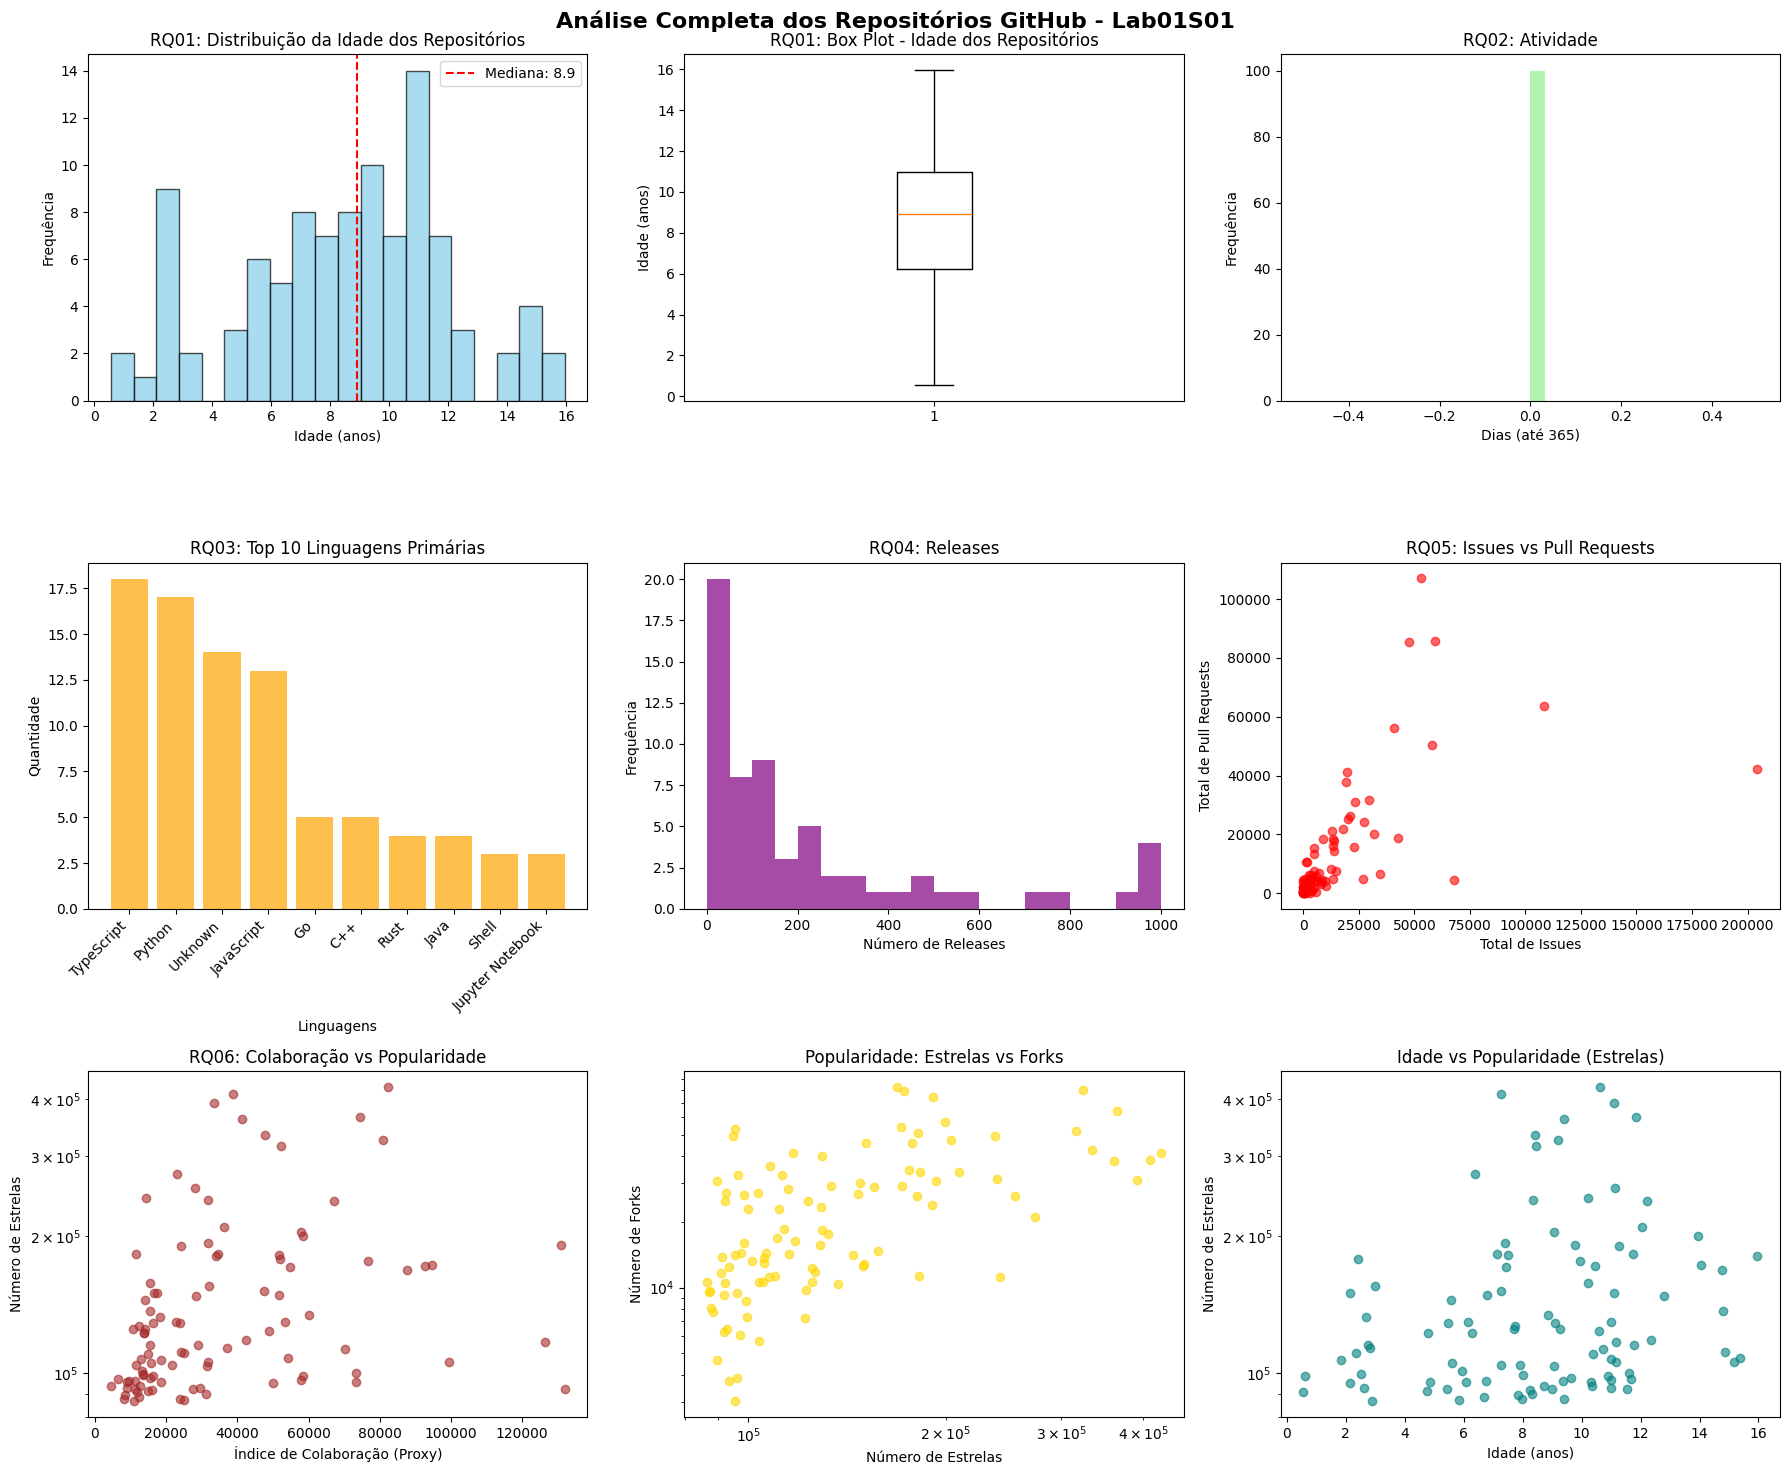


✅ Visualizações geradas!
📊 Status dos gráficos:
  ✅ RQ01 - Histograma Idade
  ✅ RQ01 - Box Plot Idade
  ✅ RQ02 - Atividade
  ✅ RQ03 - Linguagens
  ✅ RQ04 - Releases
  ✅ RQ05 - Issues vs PRs
  ✅ RQ06 - Colaboração
  ✅ Popularidade
  ✅ Idade vs Popularidade


In [14]:
def create_comprehensive_visualizations_corrected(df):


    if df is None or len(df) == 0:
        print("Não há dados para visualizar")
        return

    print("📊 GERANDO VISUALIZAÇÕES PARA TODAS AS RQs")
    print("🔧 Verificando campos disponíveis antes de criar gráficos")

    # Verificar campos disponíveis
    available_fields = list(df.columns)
    print(f"📋 Campos disponíveis: {len(available_fields)} total")

    # Configurar estilo
    plt.style.use('default')
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Análise Completa dos Repositórios GitHub - Lab01S01', fontsize=16, fontweight='bold')

    # RQ01: Distribuição de Idades
    if 'age_years' in available_fields:
        axes[0,0].hist(df['age_years'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
        axes[0,0].set_title('RQ01: Distribuição da Idade dos Repositórios')
        axes[0,0].set_xlabel('Idade (anos)')
        axes[0,0].set_ylabel('Frequência')
        axes[0,0].axvline(df['age_years'].median(), color='red', linestyle='--',
                         label=f'Mediana: {df["age_years"].median():.1f}')
        axes[0,0].legend()
    else:
        axes[0,0].text(0.5, 0.5, 'Campo age_years\nnão disponível',
                      ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('RQ01: Idade - Campo Ausente')

    # RQ01: Box Plot Idade
    if 'age_years' in available_fields:
        axes[0,1].boxplot(df['age_years'])
        axes[0,1].set_title('RQ01: Box Plot - Idade dos Repositórios')
        axes[0,1].set_ylabel('Idade (anos)')
    else:
        axes[0,1].text(0.5, 0.5, 'Campo age_years\nnão disponível',
                      ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('RQ01: Box Plot - Campo Ausente')

    # RQ02: Atividade (Dias desde última atualização)
    if 'days_since_last_update' in available_fields:
        update_days = df['days_since_last_update'].dropna()
        if len(update_days) > 0:
            # Filtrar para mostrar apenas até 365 dias para melhor visualização
            update_days_filtered = update_days[update_days <= 365]
            if len(update_days_filtered) > 0:
                axes[0,2].hist(update_days_filtered, bins=30, alpha=0.7, color='lightgreen')
                axes[0,2].set_title('RQ02: Atividade - Dias Desde Última Atualização')
                axes[0,2].set_xlabel('Dias (até 365)')
                axes[0,2].set_ylabel('Frequência')
            else:
                axes[0,2].text(0.5, 0.5, 'Todos os repos\nmuito inativos',
                              ha='center', va='center', transform=axes[0,2].transAxes)
        else:
            axes[0,2].text(0.5, 0.5, 'Sem dados de\natividade',
                          ha='center', va='center', transform=axes[0,2].transAxes)
    else:
        axes[0,2].text(0.5, 0.5, 'Campo days_since_last_update\nnão disponível',
                      ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('RQ02: Atividade')

    # RQ03: Top 10 Linguagens
    if 'primary_language' in available_fields:
        top_languages = df['primary_language'].value_counts().head(10)
        if len(top_languages) > 0:
            axes[1,0].bar(range(len(top_languages)), top_languages.values, color='orange', alpha=0.7)
            axes[1,0].set_title('RQ03: Top 10 Linguagens Primárias')
            axes[1,0].set_xlabel('Linguagens')
            axes[1,0].set_ylabel('Quantidade')
            axes[1,0].set_xticks(range(len(top_languages)))
            axes[1,0].set_xticklabels(top_languages.index, rotation=45, ha='right')
        else:
            axes[1,0].text(0.5, 0.5, 'Sem dados de\nlinguagens',
                          ha='center', va='center', transform=axes[1,0].transAxes)
    else:
        axes[1,0].text(0.5, 0.5, 'Campo primary_language\nnão disponível',
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('RQ03: Linguagens - Campo Ausente')

    # RQ04: Distribuição de Releases
    release_field = None
    if 'releases_count' in available_fields:
        release_field = 'releases_count'
    elif 'release_count' in available_fields:
        release_field = 'release_count'

    if release_field:
        releases_data = df[df[release_field] > 0][release_field]
        if len(releases_data) > 0:
            axes[1,1].hist(releases_data, bins=20, alpha=0.7, color='purple')
            axes[1,1].set_title('RQ04: Distribuição de Releases')
            axes[1,1].set_xlabel('Número de Releases')
            axes[1,1].set_ylabel('Frequência')
        else:
            axes[1,1].text(0.5, 0.5, 'Nenhum repositório\ncom releases',
                          ha='center', va='center', transform=axes[1,1].transAxes)
    else:
        axes[1,1].text(0.5, 0.5, 'Campo releases_count\nnão disponível',
                      ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('RQ04: Releases')

    # RQ05: Issues vs Pull Requests
    if 'total_issues' in available_fields and 'total_prs' in available_fields:
        axes[1,2].scatter(df['total_issues'], df['total_prs'], alpha=0.6, color='red')
        axes[1,2].set_title('RQ05: Issues vs Pull Requests')
        axes[1,2].set_xlabel('Total de Issues')
        axes[1,2].set_ylabel('Total de Pull Requests')
    else:
        missing_fields = []
        if 'total_issues' not in available_fields:
            missing_fields.append('total_issues')
        if 'total_prs' not in available_fields:
            missing_fields.append('total_prs')

        axes[1,2].text(0.5, 0.5, f'Campos ausentes:\n{", ".join(missing_fields)}',
                      ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('RQ05: Issues vs PRs - Campos Ausentes')

    # RQ06: Colaboração - USAR CAMPO ALTERNATIVO
    collab_field = None
    if 'collaborators_count' in available_fields:
        collab_field = 'collaborators_count'
        y_label = 'Número de Colaboradores'
    elif 'collaboration_proxy' in available_fields:
        collab_field = 'collaboration_proxy'
        y_label = 'Índice de Colaboração (Proxy)'
    elif 'fork_count' in available_fields:
        collab_field = 'fork_count'
        y_label = 'Número de Forks (Proxy Colaboração)'

    if collab_field and 'star_count' in available_fields:
        axes[2,0].scatter(df[collab_field], df['star_count'], alpha=0.6, color='brown')
        axes[2,0].set_title('RQ06: Colaboração vs Popularidade')
        axes[2,0].set_xlabel(y_label)
        axes[2,0].set_ylabel('Número de Estrelas')
        if df['star_count'].max() > 1000:
            axes[2,0].set_yscale('log')
    else:
        axes[2,0].text(0.5, 0.5, 'Campos de colaboração\nnão disponíveis',
                      ha='center', va='center', transform=axes[2,0].transAxes)
        axes[2,0].set_title('RQ06: Colaboração - Campos Ausentes')

    # Análise complementar: Popularidade (Estrelas vs Forks)
    if 'star_count' in available_fields and 'fork_count' in available_fields:
        axes[2,1].scatter(df['star_count'], df['fork_count'], alpha=0.6, color='gold')
        axes[2,1].set_title('Popularidade: Estrelas vs Forks')
        axes[2,1].set_xlabel('Número de Estrelas')
        axes[2,1].set_ylabel('Número de Forks')
        if df['star_count'].min() > 0 and df['fork_count'].min() > 0:
            axes[2,1].set_xscale('log')
            axes[2,1].set_yscale('log')
    else:
        axes[2,1].text(0.5, 0.5, 'Campos star_count ou\nfork_count ausentes',
                      ha='center', va='center', transform=axes[2,1].transAxes)
        axes[2,1].set_title('Popularidade - Campos Ausentes')

    # Análise temporal: Idade vs Popularidade
    if 'age_years' in available_fields and 'star_count' in available_fields:
        axes[2,2].scatter(df['age_years'], df['star_count'], alpha=0.6, color='teal')
        axes[2,2].set_title('Idade vs Popularidade (Estrelas)')
        axes[2,2].set_xlabel('Idade (anos)')
        axes[2,2].set_ylabel('Número de Estrelas')
        if df['star_count'].min() > 0:
            axes[2,2].set_yscale('log')
    else:
        axes[2,2].text(0.5, 0.5, 'Campos age_years ou\nstar_count ausentes',
                      ha='center', va='center', transform=axes[2,2].transAxes)
        axes[2,2].set_title('Idade vs Popularidade - Campos Ausentes')

    plt.tight_layout()
    plt.show()

    # Relatório dos gráficos gerados
    print("\n✅ Visualizações geradas!")
    print("📊 Status dos gráficos:")

    graphs_status = [
        ("RQ01 - Histograma Idade", 'age_years' in available_fields),
        ("RQ01 - Box Plot Idade", 'age_years' in available_fields),
        ("RQ02 - Atividade", 'days_since_last_update' in available_fields),
        ("RQ03 - Linguagens", 'primary_language' in available_fields),
        ("RQ04 - Releases", release_field is not None),
        ("RQ05 - Issues vs PRs", 'total_issues' in available_fields and 'total_prs' in available_fields),
        ("RQ06 - Colaboração", collab_field is not None),
        ("Popularidade", 'star_count' in available_fields and 'fork_count' in available_fields),
        ("Idade vs Popularidade", 'age_years' in available_fields and 'star_count' in available_fields)
    ]

    for graph_name, status in graphs_status:
        status_icon = "✅" if status else "❌"
        print(f"  {status_icon} {graph_name}")

# EXECUTAR VISUALIZAÇÕES CORRIGIDAS
print("🔄 Gerando visualizações adaptativas...")

# Verificar DataFrame disponível
if 'df_complete' in locals() and df_complete is not None:
    create_comprehensive_visualizations_corrected(df_complete)
else:
    print("❌ DataFrame não encontrado")
    print("💡 Execute primeiro as etapas de coleta e processamento")


# 9. EXPORTAÇÃO E SALVAMENTO

In [16]:
def export_lab01s01_data_corrected(df, repositories_raw):


    if df is None or len(df) == 0:
        print("Não há dados para exportar")
        return

    print("💾 EXPORTANDO DADOS LAB01S01")
    print("=" * 50)

    # Criar timestamp único
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. CSV principal com dados processados
    csv_filename = f"lab01s01_github_data_{timestamp}.csv"
    df.to_csv(csv_filename, index=False, encoding='utf-8')
    print(f"✅ CSV processado salvo: {csv_filename}")

    # 2. JSON com dados brutos (backup)
    json_filename = f"lab01s01_raw_data_{timestamp}.json"
    with open(json_filename, 'w', encoding='utf-8') as f:
        json.dump(repositories_raw, f, indent=2, ensure_ascii=False)
    print(f"✅ JSON bruto salvo: {json_filename}")

    # 3. Relatório resumo - VERIFICAR CAMPOS EXISTENTES
    report_filename = f"lab01s01_report_{timestamp}.txt"
    with open(report_filename, 'w', encoding='utf-8') as f:
        f.write("RELATÓRIO LAB01S01 - COLETA DE DADOS GITHUB\n")
        f.write("=" * 50 + "\n")
        f.write(f"Data da coleta: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}\n")
        f.write(f"Total de repositórios: {len(df)}\n")
        f.write(f"Campos coletados: {len(df.columns)}\n\n")

        f.write("CAMPOS DISPONÍVEIS:\n")
        for col in sorted(df.columns):
            f.write(f"- {col}\n")
        f.write("\n")

        f.write("ESTATÍSTICAS RESUMIDAS:\n")

        # Verificar campos antes de usar
        if 'age_years' in df.columns:
            f.write(f"Idade mediana: {df['age_years'].median():.1f} anos\n")

        if 'primary_language' in df.columns:
            most_common_lang = df['primary_language'].mode()
            if len(most_common_lang) > 0:
                f.write(f"Linguagem mais comum: {most_common_lang[0]}\n")

        if 'has_releases' in df.columns:
            f.write(f"Repositórios com releases: {df['has_releases'].sum()}\n")
        elif 'releases_count' in df.columns:
            releases_with = (df['releases_count'] > 0).sum()
            f.write(f"Repositórios com releases: {releases_with}\n")

        # Para colaboradores, usar proxy se disponível
        if 'collaborators_count' in df.columns:
            f.write(f"Mediana de colaboradores: {df['collaborators_count'].median():.0f}\n")
        elif 'collaboration_proxy' in df.columns:
            f.write(f"Mediana do índice de colaboração: {df['collaboration_proxy'].median():.0f}\n")

        # Estatísticas adicionais
        if 'star_count' in df.columns:
            f.write(f"Estrelas - Mediana: {df['star_count'].median():,.0f}\n")

        if 'total_issues' in df.columns:
            f.write(f"Issues - Mediana: {df['total_issues'].median():.0f}\n")

        if 'total_prs' in df.columns:
            f.write(f"Pull Requests - Mediana: {df['total_prs'].median():.0f}\n")

    print(f"✅ Relatório salvo: {report_filename}")

    # 4. Download no Colab
    from google.colab import files

    try:
        print("\n📥 Iniciando downloads...")
        files.download(csv_filename)
        files.download(json_filename)
        files.download(report_filename)
        print("✅ Downloads concluídos!")
    except Exception as e:
        print(f"⚠️ Downloads não disponíveis: {str(e)[:100]}")

    # 5. Verificação de integridade dos dados
    print(f"\n📊 VERIFICAÇÃO DE INTEGRIDADE:")
    print(f"📁 Arquivos gerados: 3")
    print(f"📊 Registros no CSV: {len(df)}")
    print(f"📊 Campos no DataFrame: {len(df.columns)}")
    print(f"📦 Tamanho dos dados brutos: {len(repositories_raw)} repositórios")

    # Listar campos realmente disponíveis
    print(f"\n🔍 CAMPOS COLETADOS:")
    available_fields = list(df.columns)

    # Agrupar por categoria
    identification_fields = [f for f in available_fields if f in ['name', 'full_name', 'url', 'description']]
    rq01_fields = [f for f in available_fields if 'age' in f or 'created' in f]
    rq02_fields = [f for f in available_fields if 'update' in f or 'push' in f or 'days_since' in f]
    rq03_fields = [f for f in available_fields if 'language' in f]
    rq04_fields = [f for f in available_fields if 'release' in f]
    rq05_fields = [f for f in available_fields if 'issue' in f or 'pr' in f.lower()]
    rq06_fields = [f for f in available_fields if 'collabor' in f or 'proxy' in f]

    print(f"📋 Identificação: {identification_fields}")
    print(f"🎯 RQ01 (Idade): {rq01_fields}")
    print(f"🎯 RQ02 (Atividade): {rq02_fields}")
    print(f"🎯 RQ03 (Linguagens): {rq03_fields}")
    print(f"🎯 RQ04 (Releases): {rq04_fields}")
    print(f"🎯 RQ05 (Issues/PRs): {rq05_fields}")
    print(f"🎯 RQ06 (Colaboração): {rq06_fields}")

    # Resumo final
    print(f"\n🎉 EXPORTAÇÃO CORRIGIDA CONCLUÍDA!")
    print(f"📁 Arquivos gerados:")
    print(f"   📊 {csv_filename} - Dados processados")
    print(f"   📄 {json_filename} - Dados brutos")
    print(f"   📋 {report_filename} - Relatório detalhado")

    return csv_filename, json_filename, report_filename

# EXECUTAR EXPORTAÇÃO CORRIGIDA
print("🔄 Executando exportação corrigida...")

# Verificar variáveis disponíveis
if 'df_complete' in locals() and 'repositories_data_final' in locals():
    export_files_corrected = export_lab01s01_data_corrected(df_complete, repositories_data_final)
elif 'df_complete' in locals() and 'repositories_data' in locals():
    export_files_corrected = export_lab01s01_data_corrected(df_complete, repositories_data)
else:
    print("❌ Variáveis de dados não encontradas")
    print("💡 Execute primeiro as etapas de coleta e processamento")


🔄 Executando exportação corrigida...
💾 EXPORTANDO DADOS LAB01S01
✅ CSV processado salvo: lab01s01_github_data_20250813_192416.csv
✅ JSON bruto salvo: lab01s01_raw_data_20250813_192416.json
✅ Relatório salvo: lab01s01_report_20250813_192416.txt

📥 Iniciando downloads...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloads concluídos!

📊 VERIFICAÇÃO DE INTEGRIDADE:
📁 Arquivos gerados: 3
📊 Registros no CSV: 100
📊 Campos no DataFrame: 28
📦 Tamanho dos dados brutos: 100 repositórios

🔍 CAMPOS COLETADOS:
📋 Identificação: ['name', 'full_name', 'url', 'description']
🎯 RQ01 (Idade): ['created_at', 'age_days', 'age_years', 'primary_language']
🎯 RQ02 (Atividade): ['updated_at', 'pushed_at', 'days_since_last_update', 'days_since_last_push']
🎯 RQ03 (Linguagens): ['primary_language']
🎯 RQ04 (Releases): ['releases_count', 'has_releases']
🎯 RQ05 (Issues/PRs): ['primary_language', 'total_issues', 'total_prs', 'open_issues', 'merged_prs', 'issues_ratio', 'pr_merge_ratio', 'collaboration_proxy']
🎯 RQ06 (Colaboração): ['collaboration_proxy']

🎉 EXPORTAÇÃO CORRIGIDA CONCLUÍDA!
📁 Arquivos gerados:
   📊 lab01s01_github_data_20250813_192416.csv - Dados processados
   📄 lab01s01_raw_data_20250813_192416.json - Dados brutos
   📋 lab01s01_report_20250813_192416.txt - Relatório detalhado


# 11. Verificação de Variáveis
Use quando:

❌ Etapa 7 retorna "Não há dados para processar"

❌ Erro de variável não encontrada

❌ Confusão sobre qual variável tem os dados

🔍 Precisar verificar se a coleta funcionou

Fluxo recomendado:

Execute Etapa 6 (Lab01S01)

Se Etapa 7 falhar → Execute Etapa 11

Etapa 11 identifica a variável correta

Re-execute Etapa 7 com a variável correta

In [17]:
# Verificar quais variáveis de repositórios existem
print("🔍 VERIFICANDO VARIÁVEIS DE DADOS:")
print("=" * 40)

# Lista de possíveis nomes de variáveis
possible_vars = [
    'repositories_data_final',
    'repositories_data',
    'repositories',
    'complete_data',
    'repositories_data_fixed',
    'repositories_data_revised'
]

found_data = False
data_var = None

for var_name in possible_vars:
    if var_name in locals():
        var_value = locals()[var_name]
        if var_value and len(var_value) > 0:
            print(f"✅ {var_name}: {len(var_value)} repositórios")
            if not found_data:
                found_data = True
                data_var = var_name
        else:
            print(f"❌ {var_name}: vazio ou None")
    else:
        print(f"❌ {var_name}: não existe")

if found_data:
    print(f"\n🎯 USANDO: {data_var}")
    df_complete = process_and_analyze_data_corrected(locals()[data_var])
else:
    print("\n❌ Nenhuma variável com dados encontrada")
    print("💡 Execute novamente o Lab01S01 para coletar os dados")


🔍 VERIFICANDO VARIÁVEIS DE DADOS:
✅ repositories_data_final: 100 repositórios
❌ repositories_data: não existe
❌ repositories: não existe
❌ complete_data: não existe
❌ repositories_data_fixed: não existe
❌ repositories_data_revised: não existe

🎯 USANDO: repositories_data_final
PROCESSANDO DADOS COLETADOS
📦 Dataset criado: 100 repositórios × 28 campos

📈 ESTATÍSTICAS GERAIS:
⭐ Estrelas - Mediana: 119,996 | Média: 149,681
🍴 Forks - Mediana: 18,460 | Média: 24,904

🎯 RQ01 - MATURIDADE DOS REPOSITÓRIOS:
📅 Idade Mediana: 8.9 anos
📅 Idade Média: 8.5 anos
📅 Mais antigo: 16.0 anos
📅 Mais novo: 0.6 anos
📊 Repositórios maduros (≥5 anos): 83/100 (83.0%)
📊 Repositórios jovens (<2 anos): 3/100 (3.0%)

🎯 RQ02 - ATIVIDADE DOS REPOSITÓRIOS:
🔄 Dias desde última atualização - Mediana: 0 dias
🔥 Muito ativos (≤7 dias): 100/100 (100.0%)
⚡ Ativos (≤30 dias): 100/100 (100.0%)
😴 Inativos (>90 dias): 0/100 (0.0%)

🎯 RQ03 - LINGUAGENS:
🔝 Top 10 linguagens mais populares:
    1. TypeScript: 18 repositórios (18.0

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# 12. VERIFICAÇÃO PRÉVIA DE CAMPOS
Use especificamente quando:

❌ Etapa 8 (Visualizações) apresenta erros de campo

🔍 Quiser saber cobertura de dados por RQ

📊 Precisar de diagnóstico focado em visualizações

⚠️ Antes de executar Etapa 8 para prevenir erros

Fluxo recomendado:

Etapa 8 falha com KeyError

Execute Etapa 13 para diagnóstico rápido

Etapa 13 mostra cobertura por RQ

Re-execute Etapa 8 corrigida baseado no diagnóstico

A Etapa 13 é o troubleshooting mais específico e focado para visualizações! 🎯

In [18]:
def check_available_fields():
    """Verificar quais campos estão disponíveis no DataFrame"""

    print("🔍 VERIFICAÇÃO DE CAMPOS DISPONÍVEIS")
    print("=" * 40)

    # Encontrar DataFrame
    df_var = None
    for var_name in ['df_complete', 'df_final', 'df']:
        if var_name in locals() and locals()[var_name] is not None:
            df_var = locals()[var_name]
            print(f"✅ DataFrame encontrado: {var_name}")
            break

    if df_var is None:
        print("❌ Nenhum DataFrame encontrado")
        return

    print(f"📊 Total de campos: {len(df_var.columns)}")
    print(f"📊 Total de registros: {len(df_var)}")

    print(f"\n📋 TODOS OS CAMPOS DISPONÍVEIS:")
    for i, col in enumerate(sorted(df_var.columns), 1):
        print(f"  {i:2d}. {col}")

    # Verificar campos problemáticos especificamente
    problematic_fields = ['collaborators_count', 'watcherCount', 'collaborators']
    print(f"\n🔍 VERIFICAÇÃO DE CAMPOS PROBLEMÁTICOS:")
    for field in problematic_fields:
        if field in df_var.columns:
            print(f"✅ {field}: PRESENTE")
        else:
            print(f"❌ {field}: AUSENTE (pode causar erros)")

    return df_var.columns.tolist()

# Executar verificação
available_fields = check_available_fields()


🔍 VERIFICAÇÃO DE CAMPOS DISPONÍVEIS
❌ Nenhum DataFrame encontrado


# 13. DIAGNÓSTICO RÁPIDO DE CAMPOS
Use especificamente quando:

❌ Etapa 8 (Visualizações) apresenta erros de campo

🔍 Quiser saber cobertura de dados por RQ

📊 Precisar de diagnóstico focado em visualizações

⚠️ Antes de executar Etapa 8 para prevenir erros

Fluxo recomendado:

Etapa 8 falha com KeyError

Execute Etapa 13 para diagnóstico rápido

Etapa 13 mostra cobertura por RQ

Re-execute Etapa 8 corrigida baseado no diagnóstico

A Etapa 13 é o troubleshooting mais específico e focado para visualizações! 🎯

In [19]:
def quick_field_diagnosis():
    """Diagnóstico rápido dos campos para visualizações"""

    print("🔍 DIAGNÓSTICO RÁPIDO - CAMPOS PARA VISUALIZAÇÕES")
    print("=" * 50)

    # Encontrar DataFrame
    df = None
    for var_name in ['df_complete', 'df_final', 'df']:
        if var_name in locals() and locals()[var_name] is not None:
            df = locals()[var_name]
            print(f"✅ Usando DataFrame: {var_name}")
            break

    if df is None:
        print("❌ Nenhum DataFrame encontrado")
        return

    # Campos necessários para cada RQ
    required_fields = {
        'RQ01 (Idade)': ['age_years', 'created_at'],
        'RQ02 (Atividade)': ['days_since_last_update', 'updated_at', 'pushed_at'],
        'RQ03 (Linguagens)': ['primary_language'],
        'RQ04 (Releases)': ['releases_count', 'has_releases'],
        'RQ05 (Issues/PRs)': ['total_issues', 'total_prs', 'open_issues', 'merged_prs'],
        'RQ06 (Colaboração)': ['collaborators_count', 'collaboration_proxy', 'fork_count'],
        'Geral': ['star_count', 'fork_count', 'name', 'full_name']
    }

    available_fields = set(df.columns)

    print(f"📊 Total de campos disponíveis: {len(available_fields)}")
    print(f"📊 Total de registros: {len(df)}")

    print(f"\n📋 STATUS POR RQ:")
    for rq_name, fields in required_fields.items():
        print(f"\n🎯 {rq_name}:")
        available_count = 0
        for field in fields:
            if field in available_fields:
                print(f"  ✅ {field}")
                available_count += 1
            else:
                print(f"  ❌ {field}")

        coverage = (available_count / len(fields)) * 100
        print(f"  📊 Cobertura: {coverage:.0f}% ({available_count}/{len(fields)})")

    # Campos problemáticos conhecidos
    problematic_fields = ['collaborators_count', 'watcherCount', 'watcher_count']
    print(f"\n⚠️ CAMPOS PROBLEMÁTICOS CONHECIDOS:")
    for field in problematic_fields:
        if field in available_fields:
            print(f"  ⚠️ {field}: PRESENTE (pode causar problemas)")
        else:
            print(f"  ✅ {field}: AUSENTE (problema resolvido)")

# Executar diagnóstico
quick_field_diagnosis()


🔍 DIAGNÓSTICO RÁPIDO - CAMPOS PARA VISUALIZAÇÕES
❌ Nenhum DataFrame encontrado
